In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# plt.style.use('ggplot')
sns.set_style('whitegrid')

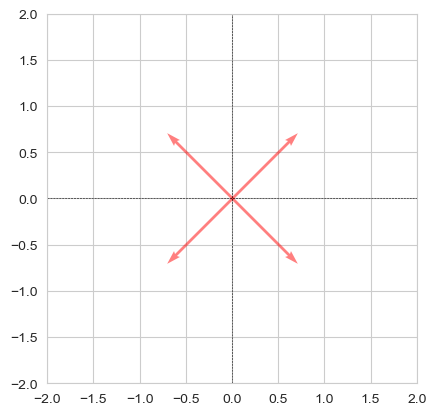

In [9]:
# define directions (angles) to test
# lets start with 4 directions

vertices = [ # get these by dir cosines from angle array
    np.array([np.sqrt(2)/2, np.sqrt(2)/2]),
    np.array([-np.sqrt(2)/2, np.sqrt(2)/2]),
    np.array([-np.sqrt(2)/2, -np.sqrt(2)/2]),
    np.array([np.sqrt(2)/2, -np.sqrt(2)/2])
]

def plot_experimental_design(vertices):
    # plot vertices in cartesian coordinates with arrows

    fig, ax = plt.subplots()

    for v in vertices:
        ax.quiver(0, 0, v[0], v[1], angles='xy', scale_units='xy', scale=1, color='r', alpha=0.5)

    ax.set_aspect('equal')
    ax.grid(True)
    ax.axhline(0, color='k', linestyle='--', linewidth=0.4)
    ax.axvline(0, color='k', linestyle='--', linewidth=0.4)

    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    # plt.axis('off')

plot_experimental_design(vertices)

tested motion directions in red

In [10]:
# check if motion direction vectors are normalized
for i in range(len(vertices)):
    assert np.sqrt(vertices[i][0]**2 + vertices[i][1]**2) == 1

In [11]:
def discharge_rate(phi_preferred: float, phi_motion: float) -> float:
    # b, k = np.random.normal(loc=10, scale=4, size=2)
    b, k = np.random.lognormal(mean=2.5, sigma=0.2, size=2)
    return b + k * np.cos(phi_preferred - phi_motion)


def get_regression_coefficients(vertices: list[np.ndarray], discharge_rates: list[float]) -> tuple[float, ...]:
    Y = discharge_rates
    X = vertices

    # assert np.linalg.matrix_rank(vertices) > 1

    X_design = sm.add_constant(X, has_constant='add')
    model = sm.OLS(Y, X_design).fit()
    # model.summary()

    return model.params


def compute_cardinal_direction_vector(params: tuple[float, ...]) -> np.ndarray: # C vector
    _, b_x, b_y = params
    k = np.sqrt(b_x**2 + b_y**2)
    
    return np.array([b_x/k, b_y/k])


def compute_vectorial_contribution(params: tuple[float, ...], discharge_rate: float) -> np.ndarray: # N vector
    
    # extract coefficients (bs)
    b, _, _ = params

    C = compute_cardinal_direction_vector(params)
    
    # vector weight
    w_M = discharge_rate - b
    
    # weighted direction vector
    N_M = w_M * C
    
    return N_M


normalize = lambda v: v / np.linalg.norm(v)


def direction_cosines(v: np.ndarray) -> np.ndarray:
    basis = np.array([[1,0], [0,1]])
    normalize = lambda v: v / np.linalg.norm(v)

    cos_x = normalize(v) @ basis[0]
    cos_y = normalize(v) @ basis[1]
    
    return np.array([cos_x, cos_y])


def compute_angle(v1: np.ndarray, v2: np.ndarray) -> np.float64:
    v1_u, v2_u = normalize(v1), normalize(v2)
    return np.arccos(np.clip((v1_u @ v2_u), -1.0, 1.0))


#### initialize

In [39]:
class Cell:
    def __init__(self, phi_preferred, tested_angles):
        self.preferred_angle = phi_preferred
        self.discharge_rates_cos = [discharge_rate(self.preferred_angle, phi) for phi in tested_angles]
        # self.discharge_random = np.random.uniform(low=0.05, high=50, size=len(tested_angles))
        self.discharge_random = np.random.normal(loc=np.pi/8, scale=np.pi/8, size=len(tested_angles))
    
    def __repr__(self):
        return f'Cell(preferred_angle={self.preferred_angle}'

In [13]:
tested_angles = [np.pi/4, 3*np.pi/4, 5*np.pi/4, 7*np.pi/4] # part of design
# preferred_angle = tested_angles[2]

In [40]:
cells = [Cell(tested_angles[j] + np.pi/4, 
              tested_angles
              ) for j in range(len(tested_angles)) 
                for i in range(50)]

cells_directional = [Cell(np.random.normal(loc=np.pi, scale=np.pi/8), 
                        tested_angles
                        ) for j in range(len(tested_angles)) 
                        for i in range(25)] + \
                    [Cell(np.random.normal(loc=np.pi/8, scale=np.pi/8), 
                        tested_angles
                        ) for j in range(len(tested_angles)) 
                        for i in range(25)]

cells_uniform = [Cell(np.random.uniform(low=0, high=2*np.pi), 
                      tested_angles
                      ) for j in range(len(tested_angles)) 
                      for i in range(50)]

In [15]:
tested_angle_idx = 3

#### cosine tuning, uniformly distributed preferred direction vectors

[ 848.89208868 -886.35119948]


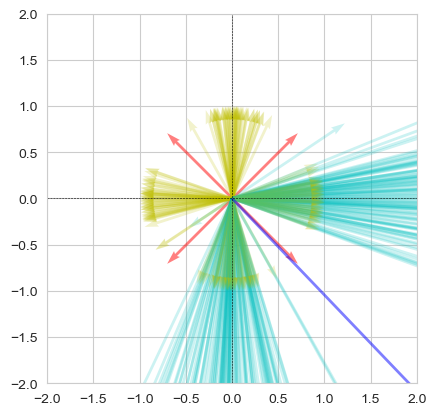

In [16]:
Ns = np.empty((len(cells), 2))

plot_experimental_design(vertices)


for i, c in enumerate(cells):
    params = get_regression_coefficients(vertices, c.discharge_rates_cos)
    C = compute_cardinal_direction_vector(params)
    # print(C); 
    plt.quiver(0, 0, C[0], C[1], angles='xy', scale_units='xy', scale=1, color='y', alpha=0.2)
    N = compute_vectorial_contribution(params, c.discharge_rates_cos[tested_angle_idx])
    plt.quiver(0, 0, N[0], N[1], angles='xy', scale_units='xy', scale=1, color='c', alpha=0.2)
    Ns[i, :] = N

P = np.sum(Ns, axis=0)

print(P)
plt.quiver(0, 0, P[0], P[1], angles='xy', scale_units='xy', scale=1, color='b', alpha=0.5)

#### cosine tuning, bimodal PDs
(Scott et al, 2001)

[1188.18206183 -129.78705859]


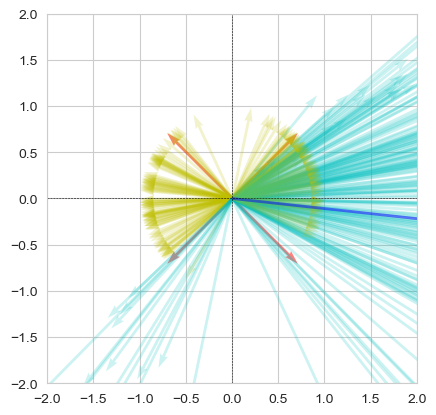

In [17]:
Ns = np.empty((len(cells_directional), 2))

plot_experimental_design(vertices)


for i, c in enumerate(cells_directional):
    params = get_regression_coefficients(vertices, c.discharge_rates_cos)
    C = compute_cardinal_direction_vector(params)
    # print(C); 
    plt.quiver(0, 0, C[0], C[1], angles='xy', scale_units='xy', scale=1, color='y', alpha=0.2)
    N = compute_vectorial_contribution(params, c.discharge_rates_cos[tested_angle_idx])
    plt.quiver(0, 0, N[0], N[1], angles='xy', scale_units='xy', scale=1, color='c', alpha=0.2)
    Ns[i, :] = N

P = np.sum(Ns, axis=0)

print(P)
plt.quiver(0, 0, P[0], P[1], angles='xy', scale_units='xy', scale=1, color='b', alpha=0.5)

In [18]:
np.rad2deg(compute_angle(vertices[tested_angle_idx], P))

38.76620339348972

#### randomly spiking cells

this is equivalent with having uniformly distributed tuning curves 

[ 22.47833778 -26.02876586]


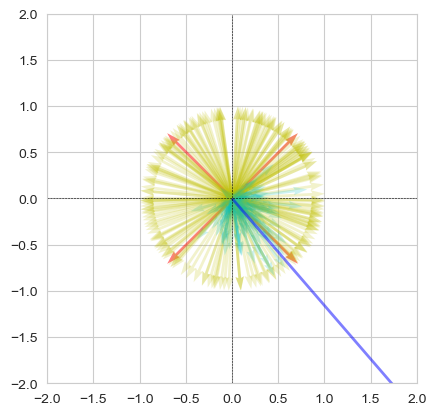

In [41]:
Ns = np.empty((len(cells), 2))

plot_experimental_design(vertices)


for i, c in enumerate(cells):
    params = get_regression_coefficients(vertices, c.discharge_random)
    C = compute_cardinal_direction_vector(params)
    # print(C); 
    plt.quiver(0, 0, C[0], C[1], angles='xy', scale_units='xy', scale=1, color='y', alpha=0.2)
    N = compute_vectorial_contribution(params, c.discharge_random[tested_angle_idx])
    plt.quiver(0, 0, N[0], N[1], angles='xy', scale_units='xy', scale=1, color='c', alpha=0.2)
    Ns[i, :] = N

P = np.sum(Ns, axis=0)

print(P)
plt.quiver(0, 0, P[0], P[1], angles='xy', scale_units='xy', scale=1, color='b', alpha=0.5)

### cosine tuning, uniform preferred directions in $\left[0, 2\pi\right]$

maybe start with this

[ 918.47635062 -863.58151998]


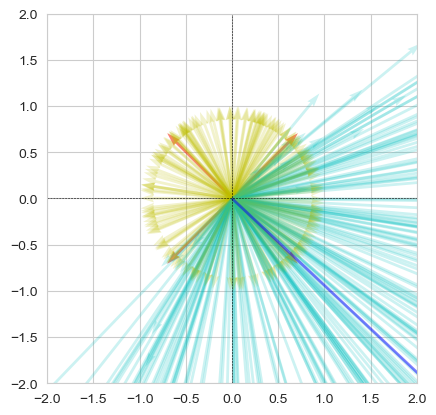

In [20]:
Ns = np.empty((len(cells), 2))

plot_experimental_design(vertices)


for i, c in enumerate(cells_uniform):
    params = get_regression_coefficients(vertices, c.discharge_rates_cos)
    C = compute_cardinal_direction_vector(params)
    # print(C); 
    plt.quiver(0, 0, C[0], C[1], angles='xy', scale_units='xy', scale=1, color='y', alpha=0.2)
    N = compute_vectorial_contribution(params, c.discharge_rates_cos[tested_angle_idx])
    plt.quiver(0, 0, N[0], N[1], angles='xy', scale_units='xy', scale=1, color='c', alpha=0.2)
    Ns[i, :] = N

P = np.sum(Ns, axis=0)

print(P)
plt.quiver(0, 0, P[0], P[1], angles='xy', scale_units='xy', scale=1, color='b', alpha=0.5)